In [1]:
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
import matplotlib.pyplot as plt
import string
import re
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, accuracy_score

In [2]:
# use this do download stopwords if you haven't done this before
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dermotobrien/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# loading in dataframe, using special encoder parameter to save it correctly
df = pd.read_csv('twitter_data.csv',encoding= 'unicode_escape')

In [4]:
# renaming the columns
df = df.rename(columns={"tweet_text": "tweet", "emotion_in_tweet_is_directed_at": "subject", "is_there_an_emotion_directed_at_a_brand_or_product": "emotion"})

In [5]:
df['tweet'] = df['tweet'].str.lower()

In [6]:
df_binary = df.loc[(df['emotion'] == 'Positive emotion' ) | (df['emotion'] == 'Negative emotion' )]

In [7]:
df_binary.loc[df_binary['emotion'] == 'Positive emotion' , 'emotion_label'] = 0
df_binary.loc[df_binary['emotion'] == 'Negative emotion' , 'emotion_label'] = 1

/Users/dermotobrien/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/dermotobrien/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [8]:
# function to label new column based on the product category 

def label_brand(row):
    if row['subject'] == 'iPad':
        return 'Apple'
    elif row['subject'] == 'Apple':
        return 'Apple'
    elif row['subject'] == 'iPad or iPhone App':
        return 'Apple'
    elif row['subject'] == 'iPhone':
        return 'Apple'
    elif row['subject'] == 'Other Apple product or service':
        return 'Apple'
    elif row['subject'] == 'Google':
        return 'Google'
    elif row['subject'] == 'Other Google product or service':
        return 'Google'
    elif row['subject'] == 'Android App':
        return 'Google'
    elif row['subject'] == 'Android':
        return 'Google'
    elif row['subject'] == np.nan: 
        return np.nan

In [9]:
df_binary['company'] = df_binary.apply(lambda row: label_brand(row), axis=1)

<ipython-input-9-3c2e651705a5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary['company'] = df_binary.apply(lambda row: label_brand(row), axis=1)


In [10]:
apple_words = ['apple','ipad','iphone','itunes']
google_words = ['google','android']

In [11]:
df_binary.loc[(df_binary['subject'].isna()) & (df_binary['tweet'].str.contains('|'.join(apple_words))),'company'] = 'Apple'

In [12]:
df_binary.loc[(df_binary['subject'].isna()) & (df_binary['tweet'].str.contains('|'.join(google_words))),'company'] = 'Google'

In [13]:
df_binary.dropna(subset=['company'],inplace=True)

<ipython-input-13-7638a198be87>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary.dropna(subset=['company'],inplace=True)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_binary['tweet'], df_binary['emotion_label'], train_size=.9)

In [15]:
og_stopwords = stopwords.words('english')

## Baseline Model

In [16]:
tfidf_baseline = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)",stop_words = og_stopwords)
baseline_vectorized = tfidf_baseline.fit_transform(X_train)

In [17]:
baseline_model = MultinomialNB()

In [18]:
# Evaluate the classifier on baseline_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, baseline_vectorized, y_train)
baseline_cv.mean()

0.8432298608848475

In [19]:
# finding training score 
baseline_model.fit(baseline_vectorized,y_train)
baseline_train_score = baseline_model.score(baseline_vectorized,y_train)
print(baseline_train_score)

0.8570530945648759


In [20]:
#Evaluating recall
y_pred_baseline = baseline_model.predict(baseline_vectorized)
recall_score(y_train, y_pred_baseline)

0.111328125

## Iteration 1: Decision Tree

In [21]:
tfidf_1 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",stop_words = og_stopwords)
vectorized_1 = tfidf_1.fit_transform(X_train)

In [22]:
dt = DecisionTreeClassifier()

In [23]:
# Evaluate the classifier on basekube_vectorized and y_train
cv1 = cross_val_score(dt,vectorized_1, y_train)
cv1.mean()

0.8331689424681338

In [24]:
# finding training score 
dt.fit(vectorized_1,y_train)
dt1_score = dt.score(vectorized_1,y_train)
print(dt1_score)

0.9996858309770656


In [25]:
#Evaluating recall
y_pred_dt = dt.predict(baseline_vectorized)
recall_score(y_train, y_pred_baseline)

0.111328125

## Iteration 2: Random Forest

In [26]:
tfidf_2 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",stop_words = og_stopwords)
vectorized_2 = tfidf_2.fit_transform(X_train)

In [27]:
rf = RandomForestClassifier()

In [28]:
# Evaluate the random forest
cv2 = cross_val_score(rf,vectorized_2, y_train)
cv2.mean()

0.8677354541235944

In [29]:
# finding training score 
rf.fit(vectorized_2,y_train)
rf1_score = rf.score(vectorized_2,y_train)
print(rf1_score)

0.9996858309770656


In [30]:
#Evaluating recall
y_pred_rf = rf.predict(vectorized_2)
recall_score(y_train, y_pred_rf)

0.998046875

## Iteration 3: Vectorizer 

In [31]:
tfidf_3 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = og_stopwords,
                          ngram_range = (1,2),
                          min_df= 5
                         )
vectorized_3 = tfidf_3.fit_transform(X_train)

# five is the best input for our min_df parameter
# (1,2) is the best input for our ngram_range parameter

In [32]:
# Evaluate the random forest
cv3 = cross_val_score(rf,vectorized_3, y_train)
cv3.mean()

0.8658471806719785

In [33]:
# finding training score 
rf.fit(vectorized_3, y_train)
rf2_score = rf.score(vectorized_3, y_train)
print(rf2_score)

0.9996858309770656


In [34]:
#Evaluating recall
y_pred_rf2 = rf.predict(vectorized_3)
recall_score(y_train, y_pred_rf2)

0.998046875

In [35]:
# looking at the shape of our tfidf sparse matrix
# pd.DataFrame.sparse.from_spmatrix(vectorized_3, columns=tfidf_3.get_feature_names()).shape

## Iteration 4 - Random Forest

In [36]:
tfidf_4 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = og_stopwords,
                          ngram_range = (1,2),
                          min_df= 5
                         )
vectorized_4 = tfidf_4.fit_transform(X_train)

In [37]:
# grid search for random forest parameters
grid_rf1 = {"n_estimators":[100, 200, 300],
           "criterion": ["gini", "entropy", "log_loss"],
           "max_features": ["sqrt", "auto"],
           "max_depth" : [10,20,30,None],
            "min_samples_leaf" : [1,2,4],
            "min_samples_split": [2,5,10]
            }
GS_rf1 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf1,
    verbose=2)

In [38]:
# GS_rf1.fit(vectorized_4,y_train)

In [39]:
# GS_rf1.best_params_

{'criterion': 'gini',

'max_depth': None,

'max_features': 'auto',

'min_samples_leaf': 1,

'min_samples_split': 2,

'n_estimators': 200}

In [40]:
# GS_rf1.best_score_

0.8695299008634473

In [41]:
# grid search for random forest parameters
grid_rf2 = {"n_estimators":[150, 200, 250],
           "criterion": ["gini"],
           "max_features": ["auto"],
           "max_depth" : [None],
            "min_samples_leaf" : [1],
            "min_samples_split": [1,2,3]
            }
GS_rf2 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf2,
    n_jobs=-1,
    verbose=2)

In [42]:
GS_rf2.fit(vectorized_4,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   13.1s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [None],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [150, 200, 250]},
             verbose=2)

In [43]:
GS_rf2.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 200}

In [44]:
GS_rf2.best_score_

0.869302350838739

In [45]:
# grid search for random forest parameters
grid_rf3 = {"n_estimators":[175, 200, 225],
           "criterion": ["gini"],
           "max_features": ["auto"],
           "max_depth" : [None],
            "min_samples_leaf" : [1],
            "min_samples_split": [3,4,5]
            }
GS_rf3 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf3,
    n_jobs=-1,
    verbose=2)

In [46]:
GS_rf3.fit(vectorized_4,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   15.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   15.3s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [None],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [3, 4, 5],
                         'n_estimators': [175, 200, 225]},
             verbose=2)

In [47]:
GS_rf3.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 200}

In [48]:
GS_rf3.best_score_

0.8683589546123238

In [49]:
rf3 = RandomForestClassifier(n_estimators=225,
                             criterion="gini",
                             max_depth=None,
                             min_samples_split=3,
                             min_samples_leaf=1,
                             max_features="auto")

In [50]:
# Evaluate the random forest
cv4 = cross_val_score(rf3, vectorized_4, y_train)
cv4.mean()

0.8667876149008225

In [51]:
# finding training score 
rf3.fit(vectorized_4, y_train)
rf3_score = rf3.score(vectorized_4, y_train)
print(rf3_score)

0.9993716619541313


In [52]:
#Evaluating recall
y_pred_rf3 = rf3.predict(vectorized_4)
recall_score(y_train, y_pred_rf3)

0.99609375

## Incorporating Additional Stopwords

In [53]:
word_eval = pd.concat([X_train, y_train], axis=1)
word_eval_pos = word_eval.loc[word_eval["emotion_label"] == 0]
word_eval_neg = word_eval.loc[word_eval["emotion_label"] == 1]

### Positive Words

In [54]:
tfidf_pos = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = og_stopwords,
                          ngram_range = (1,2), min_df=5)

In [55]:
pos_vec = tfidf_pos.fit_transform(word_eval_pos["tweet"])

In [56]:
pos_matrix = pd.DataFrame.sparse.from_spmatrix(pos_vec, columns=tfidf_pos.get_feature_names())

In [57]:
pos_words_sorted = list(pos_matrix.mean(axis=0).sort_values(ascending=False).head(10).index)

### Negative Words

In [58]:
tfidf_neg = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = og_stopwords,
                          ngram_range = (1,2), min_df=5)

In [59]:
neg_vec = tfidf_neg.fit_transform(word_eval_neg["tweet"])

In [60]:
neg_matrix = pd.DataFrame.sparse.from_spmatrix(neg_vec, columns=tfidf_neg.get_feature_names())

In [61]:
neg_words_sorted = list(neg_matrix.mean(axis=0).sort_values(ascending=False).head(10).index)

### Shared Words

In [62]:
pos_words_sorted

['mention',
 'sxsw',
 'ipad',
 'link',
 'apple',
 'rt',
 'rt mention',
 'google',
 'iphone',
 'store']

In [63]:
neg_words_sorted

['sxsw',
 'mention',
 'ipad',
 'iphone',
 'quot',
 'google',
 'apple',
 'rt',
 'rt mention',
 'link']

In [64]:
shared_words = [word for word in pos_words_sorted if word in neg_words_sorted]
shared_words

['mention',
 'sxsw',
 'ipad',
 'link',
 'apple',
 'rt',
 'rt mention',
 'google',
 'iphone']

In [65]:
updated_stopwords = og_stopwords.copy()
updated_stopwords.extend(['sxsw', 'mention', 'link', 'apple', 'google', 'quot', 'rt', 'rt mention'])

## Iteration 5 - Random Forest with updated stopwords

In [66]:
tfidf_5 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = updated_stopwords,
                          ngram_range = (1,2),
                          min_df= 5)

vectorized_5 = tfidf_5.fit_transform(X_train)

In [67]:
rf5 = RandomForestClassifier(n_estimators=225,
                             criterion="gini",
                             max_depth=None,
                             min_samples_split=3,
                             min_samples_leaf=1,
                             max_features="auto")

In [68]:
# Evaluate the random forest
cv5 = cross_val_score(rf5, vectorized_5, y_train)
cv5.mean()

0.8702452533988921

In [69]:
# finding training score 
rf5.fit(vectorized_5, y_train)
rf5_score = rf5.score(vectorized_5, y_train)
print(rf5_score)

0.9956016336789193


In [70]:
# Evaluating recall
y_pred_rf5 = rf5.predict(vectorized_5)
recall_score(y_train, y_pred_rf5)

0.978515625

### Recreate Positive and Negative Lists

#### Positive Words

In [71]:
tfidf_pos_2 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = updated_stopwords,
                          ngram_range = (1,2), 
                          min_df=5)

pos_vec_2 = tfidf_pos_2.fit_transform(word_eval_pos["tweet"])

pos_matrix_2 = pd.DataFrame.sparse.from_spmatrix(pos_vec_2, columns=tfidf_pos_2.get_feature_names())

pos_words_sorted_2 = list(pos_matrix_2.mean(axis=0).sort_values(ascending=False).index)

In [72]:
# pos_words_sorted_2

#### Negative Words

In [73]:
tfidf_neg_2 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = updated_stopwords,
                          ngram_range = (1,2), 
                          min_df=5)

neg_vec_2 = tfidf_neg_2.fit_transform(word_eval_neg["tweet"])

neg_matrix_2 = pd.DataFrame.sparse.from_spmatrix(neg_vec_2, columns=tfidf_neg_2.get_feature_names())

neg_words_sorted_2 = list(neg_matrix_2.mean(axis=0).sort_values(ascending=False).index)

In [74]:
# neg_words_sorted_2

## Wordcloud

In [75]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [76]:
from wordcloud import WordCloud
from PIL import Image

### Positive Wordcloud

In [77]:
pos_matrix_2.T.sum(axis=1).sort_values(ascending=False).head(30)

ipad          155.232257
iphone         93.974840
store          91.410492
app            73.278368
new            57.570701
austin         55.737424
pop            47.594442
android        46.166389
amp            42.435973
pop store      37.828721
party          36.032047
get            35.629302
great          35.208180
line           32.981962
iphone app     32.829200
launch         32.661529
via            31.233904
time           30.005042
circles        29.663562
free           29.220738
like           28.726283
i'm            28.579714
one            27.933651
social         27.746545
cool           27.703712
sxswi          26.562759
awesome        26.528944
day            26.519848
maps           26.280429
w              25.563613
dtype: float64

In [78]:
pos_matrix_2.drop(['austin', 'pop', 'amp', 'get', 'circles', 'via', 'one', 'time', 'sxswi', "i'm"], axis=1, inplace=True)

In [122]:
custom_mask = np.array(Image.open("twitter_bw.png"))
pos_cloud = WordCloud(mask=custom_mask, 
                      background_color="white",
                      contour_color='black',
                      contour_width=3,
                      colormap='Greens', max_words=50).generate_from_frequencies(pos_matrix_2.T.sum(axis=1))

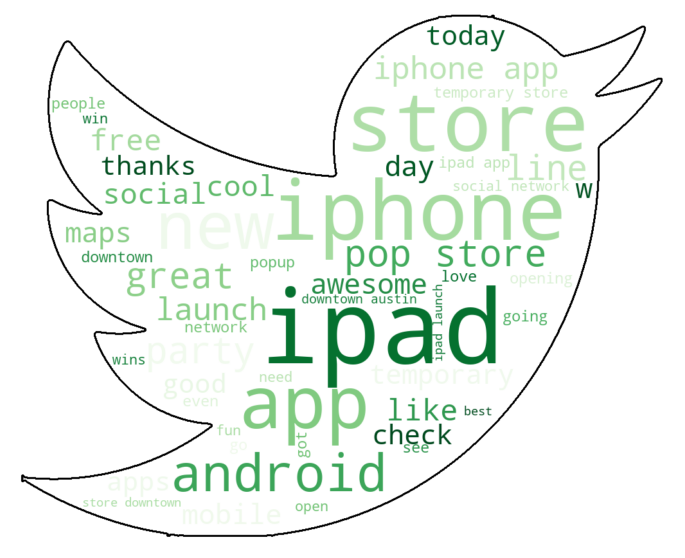

In [123]:
plt.figure(figsize=(15,10))
plt.imshow(pos_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

pos_cloud.to_file('./Results/Positive_wordcloud.png')

### Negative Wordcloud

In [81]:
neg_matrix_2.T.sum(axis=1).sort_values(ascending=False).head(30)

ipad           43.864175
iphone         41.865723
app            20.962148
store          17.001256
like           13.048751
circles        11.030874
new            11.020431
android        10.921531
austin         10.616795
people         10.584570
iphone app     10.243747
apps            9.565023
design          9.501626
social          8.986568
amp             8.521548
one             8.356401
fail            8.321826
day             7.849285
get             7.834652
need            7.817175
go              7.729246
pop             7.626616
line            7.623200
says            7.586424
time            7.298480
think           7.061693
would           6.936367
ipad design     6.885805
good            6.665374
battery         6.314897
dtype: float64

In [82]:
neg_matrix_2.drop(['like', 'new', 'austin', 'iphone app', 'apps', 'circles', 'get', 'amp', 'says', 'one', 'time', 'would', 'go', "i'm"], axis=1, inplace=True)

In [128]:
custom_mask = np.array(Image.open("twitter_dieded.png"))
neg_cloud = WordCloud(mask=custom_mask, 
                      colormap='Reds', 
                      background_color="white",
                      contour_color='black',
                      contour_width=3,
                      max_words=50).generate_from_frequencies(neg_matrix_2.T.sum(axis=1))

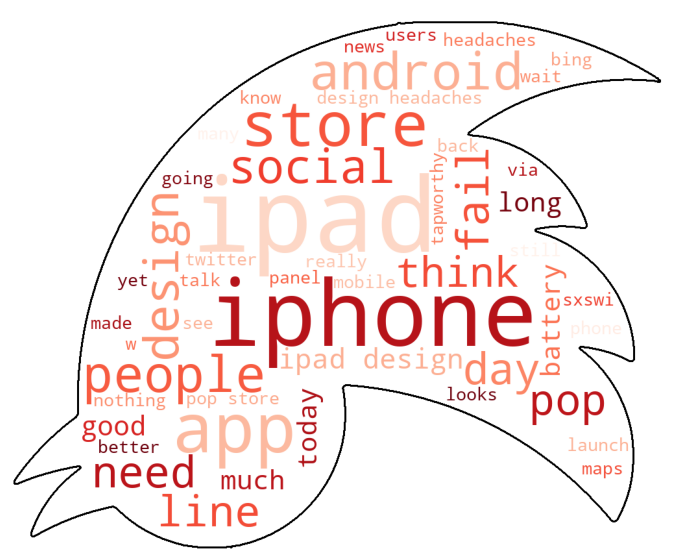

In [129]:
plt.figure(figsize=(15,10))
plt.clf()
plt.imshow(neg_cloud)
plt.axis('off')
plt.show()

neg_cloud.to_file('./Results/Negative_wordcloud.png')

## Iteration 6 - Random Forest max_depth adjustments

In [85]:
# Check max_depths of current random forest
[estimator.tree_.max_depth for estimator in rf5.estimators_]

[211,
 171,
 259,
 170,
 190,
 235,
 155,
 248,
 236,
 241,
 238,
 260,
 221,
 163,
 162,
 237,
 260,
 152,
 192,
 242,
 261,
 214,
 207,
 264,
 260,
 272,
 260,
 257,
 162,
 208,
 150,
 238,
 151,
 243,
 240,
 194,
 263,
 222,
 166,
 293,
 179,
 236,
 234,
 230,
 251,
 260,
 264,
 169,
 244,
 268,
 237,
 262,
 170,
 209,
 236,
 254,
 222,
 205,
 231,
 185,
 250,
 220,
 257,
 261,
 270,
 221,
 181,
 254,
 199,
 196,
 275,
 242,
 248,
 278,
 143,
 262,
 270,
 224,
 244,
 164,
 260,
 159,
 265,
 225,
 311,
 157,
 253,
 242,
 266,
 268,
 172,
 258,
 142,
 122,
 252,
 314,
 239,
 255,
 244,
 228,
 253,
 261,
 204,
 199,
 275,
 217,
 164,
 240,
 236,
 253,
 199,
 267,
 261,
 180,
 253,
 286,
 200,
 241,
 149,
 153,
 255,
 175,
 249,
 245,
 230,
 266,
 259,
 267,
 268,
 253,
 245,
 256,
 246,
 247,
 188,
 246,
 214,
 161,
 287,
 283,
 266,
 224,
 272,
 190,
 233,
 181,
 258,
 260,
 238,
 255,
 258,
 256,
 264,
 240,
 229,
 243,
 249,
 245,
 261,
 150,
 225,
 232,
 182,
 250,
 236,
 281,
 233

In [86]:
# grid search for random forest parameters
grid_rf4 = {"n_estimators":[225],
           "criterion": ["gini"],
           "max_features": ["auto"],
           "max_depth" : [50,100,150,200],
            "min_samples_leaf" : [1],
            "min_samples_split": [3]
            }
GS_rf4 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf4,
    n_jobs=-1,
    verbose=2,
    scoring='recall')

In [87]:
tfidf_6 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = updated_stopwords,
                          ngram_range = (1,2),
                          min_df= 5,
                         )
vectorized_6 = tfidf_6.fit_transform(X_train)

In [88]:
GS_rf4.fit(vectorized_6, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    2.3s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.4s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'],
                         'max_depth': [50, 100, 150, 200],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [3], 'n_estimators': [225]},
             scoring='recall', verbose=2)

In [89]:
GS_rf4.best_params_

{'criterion': 'gini',
 'max_depth': 200,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 225}

In [90]:
GS_rf4.best_score_

0.3164667808871121

### Run Final Model on Test Set

In [91]:
test_vec = tfidf_5.transform(X_test)

In [92]:
# Evaluating recall
test_pred = rf5.predict(test_vec)
recall_score(y_test, test_pred)

0.49122807017543857

In [93]:
accuracy_score(y_test, test_pred)

0.903954802259887

In [94]:
precision_score(y_test, test_pred)

0.8484848484848485

In [95]:
rf5.score(test_vec, y_test)

0.903954802259887